**Importing all the required Dependencies**

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

**Connecting to Google Drive for Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive'

Mounted at /content/drive
/content/drive/My Drive


**Initialization parameters**

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]
epochs = 500
batch_size = 32
# paths to dataset
covid_path = 'Datasets/Covid/ChestXRay/covid'
noncovid_path = 'Datasets/Covid/ChestXRay/normal'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

**Fetching the images from Drive**

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

**Visualize First 40 Images from Data set**

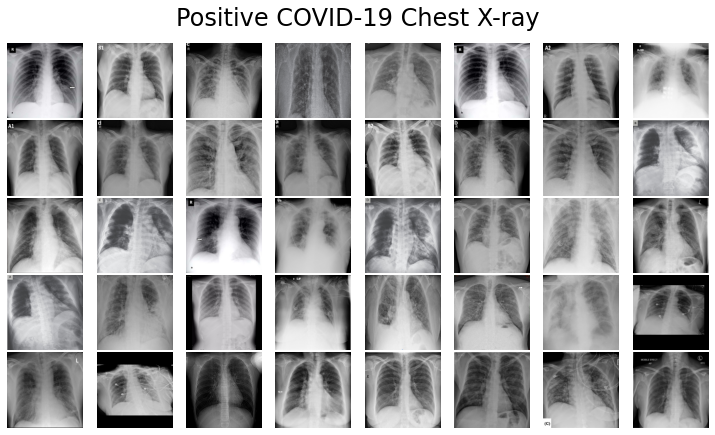

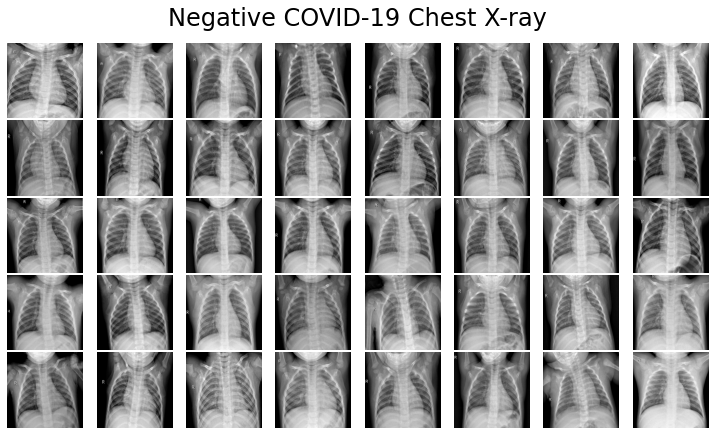

In [ ]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

**Normalization - 
Model takes images in the form of array of pixels. Hence convert into array and normalize**

In [ ]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing sets
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

**Visualize a few images from Training and Test sets**

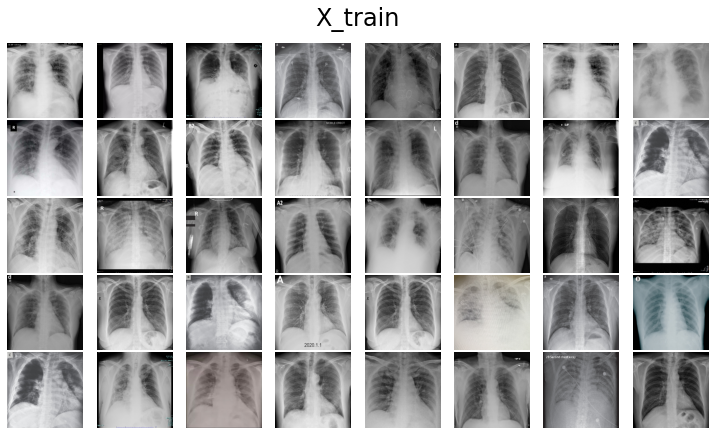

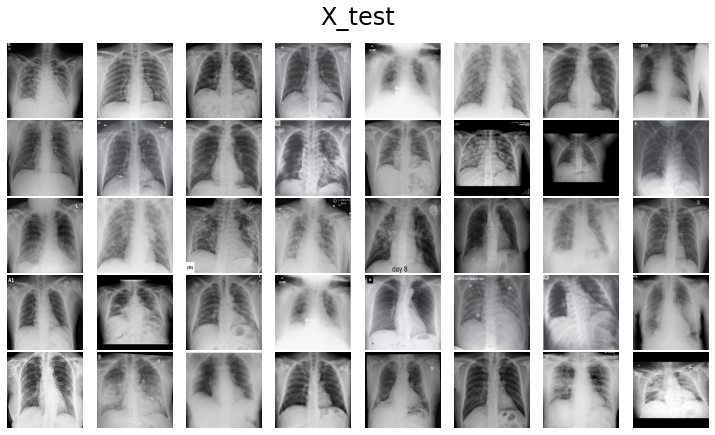

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

**Building and Visualizing model**

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
 )
test_aug = ImageDataGenerator(
    horizontal_flip=True
 )

In [ ]:
# model.summary()

**Training the model**

In [ ]:
import time
start_time2 = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100)
end_time2 = time.time()
print(end_time2 - start_time2)

In [ ]:
model.save('ResNet50_covid_chest.h5')
model.save_weights('ResNet50_covid_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_ResNet50_covid_chest.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

In [ ]:
model.save('resnet_chest.h5')

In [ ]:
model.save_weights('resnetweights_chest.hdf5')

In [ ]:
model = load_model('resnet_chest.h5')

**Making Predicions**

In [ ]:
# y_pred = model.predict(X_test, batch_size=batch_size)

**Visualising First 10 predictions**

In [ ]:
# prediction=y_pred[0:10]
# for index, probability in enumerate(prediction):
#   if probability[1] > 0.5:
#         plt.title('%.2f' % (probability[1]*100) + '% COVID')
#   else:
#         plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
#   plt.imshow(X_test[index])
#   plt.show()

In [ ]:
# Convert to Binary classes
# y_pred_bin = np.argmax(y_pred, axis=1)
# y_test_bin = np.argmax(y_test, axis=1)

**Plot ROC Curve**

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.rcParams['font.size'] = 12
# plt.title('ROC curve for our model')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)

**Plot Confusion Matrix**

In [ ]:
# def plot_confusion_matrix(normalize):
#   classes = ['COVID','NonCOVID']
#   tick_marks = [0.5,1.5]
#   cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
#   sns.heatmap(cn,cmap='plasma',annot=True)
#   plt.xticks(tick_marks, classes)
#   plt.yticks(tick_marks, classes)
#   plt.title('Confusion Matrix')
#   plt.ylabel('True label')
#   plt.xlabel('Predicted label')
#   plt.show()

# print('Confusion Matrix without Normalization')
# plot_confusion_matrix(normalize=None)

# print('Confusion Matrix with Normalized Values')
# plot_confusion_matrix(normalize='true')

**Classification Report**

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test_bin, y_pred_bin))

**Accuracy and Loss Plots**

In [ ]:
# plt.figure(figsize=(10,10))

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')

# plt.legend(['Training', 'Testing'])
# plt.savefig('resnet_chest_accuracy.png')
# plt.show()

In [ ]:
# plt.figure(figsize=(10,10))

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')

# plt.legend(['Training', 'Testing'])
# plt.savefig('resnet_chest_loss.png')
# plt.show()

In [ ]:
# VGG

In [ ]:
# from tensorflow.keras.applications import VGG19
# res = VGG19(weights="imagenet", include_top=False,
#     input_tensor=Input(shape=(224, 224, 3)))

# outputs = res.output
# outputs = Flatten(name="flatten")(outputs)
# outputs = Dropout(0.5)(outputs)
# outputs = Dense(2, activation="softmax")(outputs)

# model = Model(inputs=res.input, outputs=outputs)

# for layer in res.layers:
#     layer.trainable = False

# model.compile(
#         loss='categorical_crossentropy', 
#         optimizer='adam', 
#         metrics=['accuracy']
# )

# train_aug = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True
# )

In [ ]:
# import time
# start_time2 = time.time()
# history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
#                     validation_data=(X_test, y_test),
#                     validation_steps=len(X_test) / 32,
#                     steps_per_epoch=len(X_train) / 32,
#                     epochs=100)
# end_time2 = time.time()
# print(end_time2 - start_time2)

In [ ]:
# model.save('vgg19_covid_chest.h5')
# model.save_weights('vgg19_covid_chest.hdf5')
# import pandas as pd
# hist_df = pd.DataFrame(history.history)
# hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
# hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
# print(hist_df)
# writer = pd.ExcelWriter('output_vgg19_covid_chest.xlsx')
# # write dataframe to excel
# hist_df.to_excel(writer)
# # save the excel
# writer.save()

In [ ]:
# Inception

In [ ]:
# Exception

In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
import time
start_time = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=test_aug.flow(X_test, y_test,batch_size=32),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100)
end_time = time.time()
print(end_time - start_time)

Epoch 1/100
10/10 [==============================] - 4s 401ms/step - loss: 0.1179 - accuracy: 0.9854 - val_loss: 0.0311 - val_accuracy: 0.9885
Epoch 2/100
10/10 [==============================] - 4s 405ms/step - loss: 0.0905 - accuracy: 0.9883 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 4s 405ms/step - loss: 0.0521 - accuracy: 0.9854 - val_loss: 0.0246 - val_accuracy: 0.9885
Epoch 4/100
10/10 [==============================] - 4s 401ms/step - loss: 0.0241 - accuracy: 0.9971 - val_loss: 3.2200e-07 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 4s 404ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 0.9885
Epoch 6/100
10/10 [==============================] - 4s 404ms/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 2.5212e-07 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 4s 405ms/step - loss: 0.0462 - accuracy: 0.9883 - val_loss: 0.1313 - val_accuracy

In [ ]:
model.save('xception_chest.h5')
model.save_weights('xceptionweights_chest.hdf5')
model = load_model('xception_chest.h5')

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_xception_chest_covid19.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

    epoch_id      loss  accuracy      val_loss  val_accuracy
0          1  0.117860  0.985423  3.108979e-02      0.988506
1          2  0.090522  0.988338  2.036725e-03      1.000000
2          3  0.052096  0.985423  2.463215e-02      0.988506
3          4  0.024143  0.997085  3.219989e-07      1.000000
4          5  0.001943  1.000000  1.701338e-02      0.988506
..       ...       ...       ...           ...           ...
95        96  0.000003  1.000000  0.000000e+00      1.000000
96        97  0.000306  1.000000  2.740443e-09      1.000000
97        98  0.091863  0.991254  1.370222e-09      1.000000
98        99  0.066150  0.991254  9.317470e-08      1.000000
99       100  0.046765  0.991254  0.000000e+00      1.000000

[100 rows x 5 columns]
